In [1]:
import torch
import numpy as np
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.utils import make_grid

import score_models

from src.nn_handler.nn_handler_distributed import NNHandler

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def denoising_score_matching(samples, sde, model, device, *args):
    B, *D = samples.shape
    z = torch.randn_like(samples)
    t = torch.rand(B).to(device) * (sde.T - sde.epsilon) + sde.epsilon
    mean, sigma = sde.marginal_prob(t, samples)
    return torch.sum((z + model(t, mean + sigma * z, *args)) ** 2) / B

In [4]:
dataset = torchvision.datasets.MNIST('notebooks/.', train=True, transform=transforms.ToTensor(), download=True)
dataset = torch.utils.data.TensorDataset(dataset.data[:1000].unsqueeze(1) / 255.)
print(len(dataset))

1000


In [5]:
hyperparameters = {
    "channels": 1,
    "dimensions": 2,
    "nf": 64,
    "activation_type": "swish",
    "ch_mult": (1, 2, 4),
    "num_res_blocks": 2,
    "resample_with_conv": True,
    "dropout": 0.,
    "attention": True,
}

model = NNHandler(model_class=score_models.NCSNpp, model_type=NNHandler.ModelType.SCORE_BASED, device=device,
                  **hyperparameters, logger_mode=NNHandler.LoggingMode.FILE, logger_level=10,
                  logger_filename="notebooks/models/MNIST_score_models.log")

WARN: No DDP environment variables found. Running non-DDP.
INFO: No DDP environment detected and use_distributed=None. Running non-DDP.


In [6]:
model.set_sde(sde_class=score_models.sde.VESDE, sigma_min=1e-2, sigma_max=10)

In [7]:
model.set_loss_fn(denoising_score_matching)

In [8]:
model.set_optimizer(torch.optim.Adam, lr=1e-3)
model.set_scheduler(torch.optim.lr_scheduler.StepLR, step_size=10, gamma=0.9)

In [9]:
model.auto_save(10, "notebooks/models", "MNIST_score_models", overwrite=True)

In [10]:
model.set_train_loader(dataset, batch_size=128)

In [11]:
model.train(150, validate_every=0, ema_decay=0.99, epoch_train_and_val_pbar=False)

Epochs:   0%|          | 0/150 [00:00<?, ?epoch/s]

Sampling (prior):   0%|          | 0/100 [00:00<?, ?it/s]

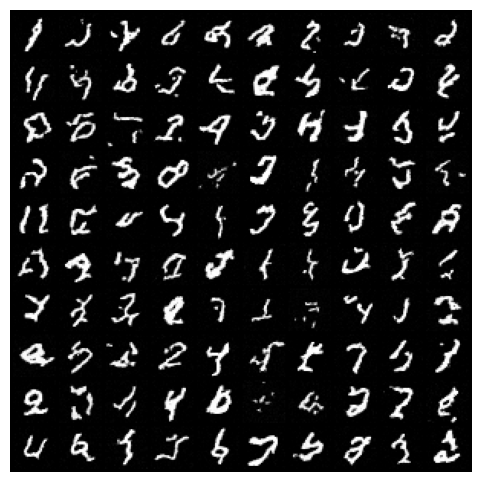

In [13]:
N = 144

samples = model.sample(shape=[N, 1, 28, 28], steps=100)

sample_grid = make_grid(samples, nrow=int(np.sqrt(N)), value_range=(0, 1), normalize=True)

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
plt.show()

Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 3.1e-01: 100%|██████████| 100/100 [00:09<00:00, 10.42it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06500413..1.0499471].


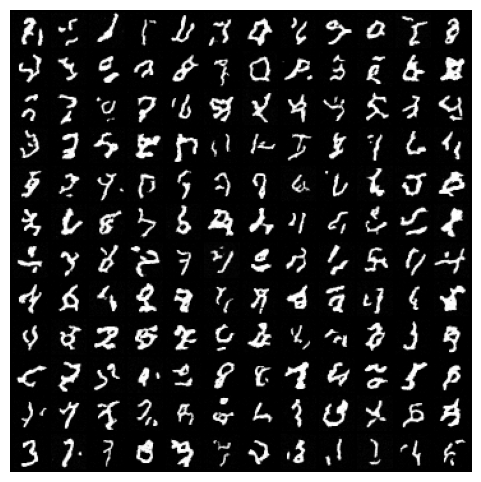

Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 3.0e-01: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.049718257..1.0381655].


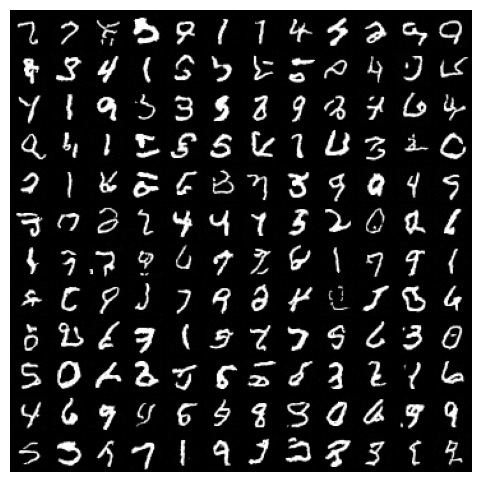

Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 3.0e-01: 100%|██████████| 100/100 [00:09<00:00, 10.25it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03708092..1.0433882].


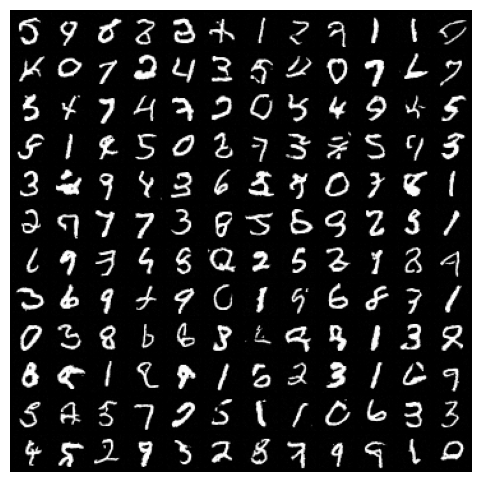

Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 3.0e-01: 100%|██████████| 100/100 [00:09<00:00, 10.44it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03821473..1.0364017].


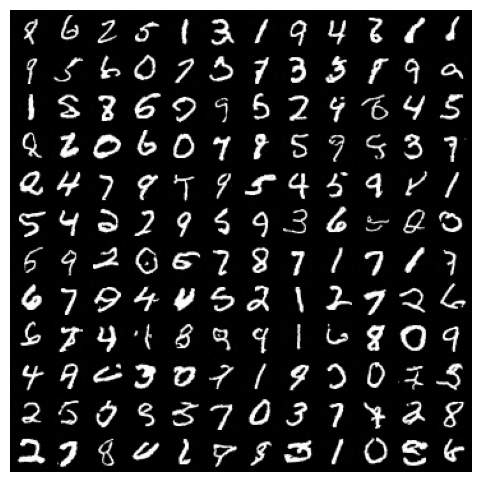

Sampling from the prior | t = 0.0 | sigma = 1.1e-02| scale ~ 3.1e-01: 100%|██████████| 100/100 [00:09<00:00, 10.45it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.038492523..1.029687].


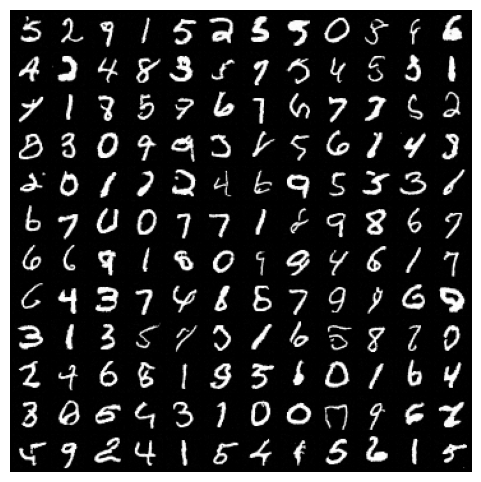

In [53]:
for i in range(10, 51, 10):
    model = NNHandler.load(f"models/MNIST_score_models_{i}.pth", device=device)

    N = 144
    samples = model.sample(shape=[N, 1, 28, 28], steps=100)

    sample_grid = make_grid(samples, nrow=int(np.sqrt(N)), value_range=(0, 1), normalize=False)
    plt.figure(figsize=(6, 6))
    plt.axis('off')
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0, vmax=1)
    plt.show()